In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random
import matplotlib.pyplot as plt
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('intent.json').read()
intents = json.loads(data_file)

In [2]:
for intent in intents['intents']:
    for pattern in intent['patterns']:
        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))
        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [3]:
# lemmatize, lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

44 documents
11 classes ['goodbye', 'greeting', 'hybrid_recommendation_effect', 'hybrid_recommendation_flavor', 'indica_recommendation_effect', 'indica_recommendation_flavor', 'sativa_recommendation_effect', 'sativia_recommendation_flavor', 'talk', 'tasks', 'thanks']
56 unique lemmatized words ["'s", ',', '.', 'ability', 'anyone', 'are', 'bye', 'can', 'citrus', 'coffee', 'creative', 'day', 'do', 'earthy', 'energetic', 'euphoria', 'favorite', 'feature', 'feel', 'flowery', 'focus', 'for', 'good', 'goodbye', 'happy', 'have', 'hello', 'helpful', 'herbal', 'hi', 'how', 'i', 'is', 'issue', 'later', 'lavender', 'recommend', 'relaxation', 'relaxed', 'see', 'sleeping', 'spicy', 'strain', 'sweet', 'talkative', 'thank', 'thanks', 'that', 'there', 'to', 'uplifted', 'want', 'what', 'with', 'you', 'your']


In [4]:
# create our training data
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
validation = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
x_val = list(validation[:,0])
y_val = list(validation[:,1])
print("Training data created")

Training data created


/var/folders/sm/_5gnbd013rb4qq7sdmm6hdwc0000gn/T/ipykernel_73990/3051308173.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)


In [5]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [6]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model 
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)
model.save('canachatbot_model.h5', hist)

print("model created")
                  

2022-08-12 00:34:57.546861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/alexandrianiccole/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/200
9/9 [==============================] - 2s 4ms/step - loss: 2.4597 - accuracy: 0.0682 
Epoch 2/200
9/9 [==============================] - 0s 5ms/step - loss: 2.4060 - accuracy: 0.1364
Epoch 3/200
9/9 [==============================] - 0s 4ms/step - loss: 2.3781 - accuracy: 0.1364
Epoch 4/200
9/9 [==============================] - 0s 6ms/step - loss: 2.3087 - accuracy: 0.1591
Epoch 5/200
9/9 [==============================] - 0s 4ms/step - loss: 2.2867 - accuracy: 0.2045
Epoch 6/200
9/9 [==============================] - 0s 4ms/step - loss: 2.3072 - accuracy: 0.0909
Epoch 7/200
9/9 [==============================] - 0s 4ms/step - loss: 2.2435 - accuracy: 0.1591
Epoch 8/200
9/9 [==============================] - 0s 4ms/step - loss: 2.2104 - accuracy: 0.2500
Epoch 9/200
9/9 [==============================] - 0s 4ms/step - loss: 2.0969 - accuracy: 0.2273
Epoch 10/200
9/9 [==============================] - 0s 4ms/step - loss: 2.1486 - accuracy: 0.2045
Epoch 11/200
9/9 [==========

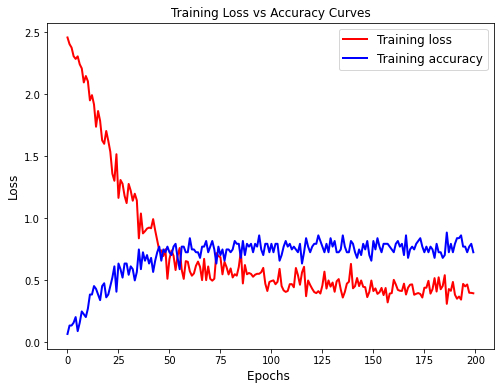

In [7]:
#Plot the Graph
# Loss Curves
loss_train = hist.history['loss']
train_accu = hist.history['accuracy']
epochs = range(5,200)
plt.figure(figsize=[8,6])
plt.plot(hist.history['loss'],'r', label='Training loss',linewidth=2.0)
plt.plot(hist.history['accuracy'],'b', label='Training accuracy',linewidth=2.0)
plt.legend(['Training loss', 'Training accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Training Loss vs Accuracy Curves',fontsize=12)
plt.show()